In [5]:
import time
import pickle
import numpy as np
import csv
import math
from matplotlib import pyplot as plt
import random

In [6]:
train_list = list(filter(lambda x: (str(x)[-1] in ['1', '5']), range(1, 201)))
test_list = list(filter(lambda x: (str(x)[-1] not in ['1', '5']), range(1, 201)))
low_result = [8, 54, 98, 154, 184, 126]
not_align = [73, 74, 76, 193]

In [7]:
def getLineFromAnnot(time, piece, data='data'):
    with open('/home/mshan/ttemp/{}/timeAnnot/0/p{}.timeannot.csv'.format(data, piece)) as csvfile:
        reader = csv.reader(csvfile)
        last_row = []
        for row in reader:
            if float(row[1]) <= time and float(row[2]) > time:
                page = int(row[0].split('L')[0][1:])
                line_on_page = int(row[0].split('L')[1])
                return page, line_on_page
            last_row = row
        page = int(last_row[0].split('L')[0][1:])
        line_on_page = int(last_row[0].split('L')[1])
        return page, line_on_page

In [8]:
def getPixel(page, line_on_page, piece):
    with open('/home/mshan/ttemp/data/lineAnnot/p{}.lineinfo.csv'.format(piece)) as csvfile:
        reader = csv.reader(csvfile)
        rows = []
        for row in reader:
            if row[0] == 'P{}L{}'.format(page, line_on_page):
                return int(row[1]), int(row[2])
        return -1, -1

In [9]:
def getPrevNext(piece, page, line_on_page):
    if line_on_page == 1:
        prev_end = 0
        prev_page = -1
    else:
        prev_page = page
        _, prev_end = getPixel(page, line_on_page - 1, piece)
    if getPixel(page, line_on_page + 1, piece)[0] == -1:
        next_start = np.inf
        next_page = -1
    else:
        next_page = page
        _, next_start = getPixel(next_page, line_on_page + 1, piece)
    return prev_end, prev_page, next_start, next_page

In [10]:
def getChangeLineInfo(piece, data='data'):
    # For scoring collars
    with open('/home/mshan/ttemp/{}/timeAnnot/0/p{}.timeannot.csv'.format(data, piece)) as csvfile:
        reader = csv.reader(csvfile)
        change_line_time = []
        for row in reader:
            change_line_time.append(float(row[-1]))
    return change_line_time[:-1]

In [11]:
def getBoundaryElements(piece, loc):
    '''
    Variable loc could be either 'F' or 'L'.
    Get all elements that are first or last element of a single line, given a piece number.
    '''
    first = []
    last = []
    with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(piece), 'rb') as f:
        d = pickle.load(f)
        for i in range(1, len(d['events'])):
            
            # check if on the same page as the previous event
            if d['events'][i][2] != d['events'][i-1][2]:
                first.append(i)
                
        for i in range(0, len(d['events'])-1):
            # check if on the same page as the next event
            if d['events'][i][2] != d['events'][i+1][2]:
                last.append(i)
                
    if loc == 'F':
        return [0] + first # 0 is also a first element
    return last + [len(d['events']) - 1] # add the last element of a piece

In [12]:
def accuracy(time, piece, events, data='data', white=0, collar=0, sys='subseqDTW', pred_lines=None, wp=None):
    accu_time = 0
    total_time = time[-1] - time[0]
    tol = 100
    if sys[:15] == 'hierarchicalDTW':
        bounds = getBoundaryElements(piece, "F")
    # for visualization
    accu_info = []
    change_line_info = []
    prev_line = 0
    
    for i in range(len(time)-1):
        is_accurate = False
        time_point = time[i]
        page, line_on_page = getLineFromAnnot(time_point, piece, data)
        start, end = getPixel(page, line_on_page, piece)
        prev_end, prev_page, next_start, next_page = getPrevNext(piece, page, line_on_page)
        # for visualization
        if line_on_page == prev_line:
            change_line_info.append('c')
        else:
            change_line_info.append('f')
        prev_line = line_on_page
        
        # Check if this prediction is correct
        change_line_list = np.asarray(getChangeLineInfo(piece, data))
        beginInCollar = sum(abs(change_line_list - time[i]) <= collar)
        endInCollar = sum(abs(change_line_list - time[i+1]) <= collar)
        if beginInCollar > 0 and endInCollar > 0:
            total_time -= time[i+1]-time[i]
            accu_info.append('c')
            is_accurate = True
         
        else:
            if sys[:15] == 'hierarchicalDTW':
                start_idx = bounds[pred_lines[i]]
                start_event = events[start_idx]
            else:
                start_event = events[wp[i][1]]
            if start_event[5] == page - white:
                cur_start = start_event[3]
                cur_end = start_event[4]
                if cur_start < start+tol and cur_end > end-tol:
                    if (page != prev_page or cur_start > prev_end + tol) and (page != next_page or cur_end < next_start - tol):
                        accu_time += time[i+1]-time[i]
                        accu_info.append('c')
                        is_accurate = True
        if not is_accurate:
            accu_info.append('w') # for visualization
            
    return accu_time, total_time, accu_info, change_line_info

In [9]:
def runBenchmark(data='data', tol=100, collar=0, alpha=0.7, verbose=True, sys='subseqDTW'):
    acc_list = []
    total_acc = 0
    total_times = 0
    for i in train_list:
        if i not in low_result:
            white = 0
            if i in [4, 6, 7, 8, 14, 29, 30, 31, 32, 48, 53, 54, 59, 62, 98, 124, 136, 140, 150, 191, 199]:
                white = 1
            if i in [133, 138]:
                white = 2
            
            if sys[:15] == 'hierarchicalDTW':
                pklfile = '/home/mshan/ttemp/data/hyp/{}/{}/{}/p{}.pkl'.format(sys, data, alpha, i)
                with open(pklfile, 'rb') as f:
                    d = pickle.load(f)
                accu_time, total_time, _, change_line_info = accuracy(d['actual_time'], i, d['events'], sys=sys, data=data, white=white, collar=collar, pred_lines=d['pred_lines'])
            else:
                pklfile = '/home/mshan/ttemp/data/hyp/{}/{}/p{}.pkl'.format(sys, data, i)
                with open(pklfile, 'rb') as f:
                    d = pickle.load(f)
                accu_time, total_time, _, change_line_info = accuracy(d['actual_time'], i, d['events'], sys=sys, data=data, white=white, collar=collar, wp=d['wp'])
            acc = accu_time / total_time
            total_acc += accu_time
            total_times += total_time
            if math.isnan(acc):
                acc = 0
            acc_list.append(acc)
            
            if verbose:
                print("Accuracy is {} for piece {}.".format(acc, i))
    return acc_list, change_line_info, total_acc / total_times

In [222]:
import time
start = time.time()
acc_list, change_line_info, total_ratio = runBenchmark(data='data_repeat3', collar=0.2, alpha=0.7, verbose=True, sys='hierarchicalDTW_v3.AD')
print("Average accuracy is: {}".format(total_ratio))
print("Average time is: {}".format((time.time()-start)/len(acc_list)))

Accuracy is 0.9530036779730278 for piece 2.
Accuracy is 0.8171411204538556 for piece 3.
Accuracy is 0.9945191828599882 for piece 4.
Accuracy is 0.8962264150943383 for piece 6.
Accuracy is 0.9279877425944872 for piece 7.
Accuracy is 0.9436647558806128 for piece 9.
Accuracy is 0.5276312135517929 for piece 10.
Accuracy is 0.9771293375394341 for piece 12.
Accuracy is 0.9181603773584947 for piece 13.
Accuracy is 0.9799732977303054 for piece 14.
Accuracy is 0.835322723253762 for piece 16.
Accuracy is 0.7537717050953653 for piece 17.
Accuracy is 0.9371951219512272 for piece 18.
Accuracy is 0.953905249679894 for piece 19.
Accuracy is 0.745521359669269 for piece 20.
Accuracy is 0.9378084896347552 for piece 22.
Accuracy is 0.9219204655674093 for piece 23.
Accuracy is 0.8997627520759187 for piece 24.
Accuracy is 0.7840501792114691 for piece 26.
Accuracy is 0.9302949061662245 for piece 27.
Accuracy is 0.949265054528212 for piece 28.
Accuracy is 0.7335142469470846 for piece 29.
Accuracy is 0.912995

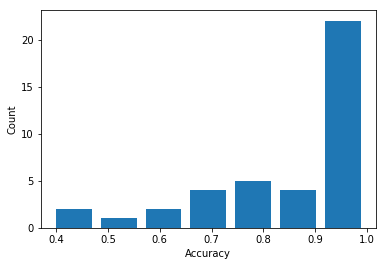

In [14]:
plt.hist(acc_list, bins='auto', rwidth=0.8)
plt.ylabel('Count');
plt.xlabel('Accuracy');

In [85]:
for collar in [0, 0.1, 0.2, 0.5, 1]:
    for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
        _, _, ratio = runBenchmark(data=data, collar=collar, verbose=False, sys='jumpDTW')
        print("Average accuracy is: {} for data {} and collar {}.".format(ratio, data, collar))

Average accuracy is: 0.7409922904450567 for data data and collar 0.
Average accuracy is: 0.7400156527424773 for data data_repeat1 and collar 0.
Average accuracy is: 0.7478546058858746 for data data_repeat2 and collar 0.
Average accuracy is: 0.7425554858730202 for data data_repeat3 and collar 0.
Average accuracy is: 0.7401806497614369 for data data_dsalfine and collar 0.
Average accuracy is: 0.7427684369869496 for data data and collar 0.1.
Average accuracy is: 0.7419289741770495 for data data_repeat1 and collar 0.1.
Average accuracy is: 0.7497440947746821 for data data_repeat2 and collar 0.1.
Average accuracy is: 0.7445209278221524 for data data_repeat3 and collar 0.1.
Average accuracy is: 0.7419704666997905 for data data_dsalfine and collar 0.1.
Average accuracy is: 0.7497821665932867 for data data and collar 0.2.
Average accuracy is: 0.7491775834547976 for data data_repeat1 and collar 0.2.
Average accuracy is: 0.7571323635143783 for data data_repeat2 and collar 0.2.
Average accuracy i

In [45]:
for collar in [0.2, 0.5, 1, 0.1]:
    for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
        _, _, ratio = runBenchmark(data=data, collar=collar, verbose=False, sys='jumpDTW')
        print("Average accuracy is: {} for data {} and collar {}.".format(ratio, data, collar))

Average accuracy is: 0.6933204207574355 for data data and collar 0.2.
Average accuracy is: 0.6893227950118043 for data data_repeat1 and collar 0.2.
Average accuracy is: 0.6795988126341197 for data data_repeat2 and collar 0.2.
Average accuracy is: 0.6860881133946692 for data data_repeat3 and collar 0.2.
Average accuracy is: 0.6791218101757919 for data data_dsalfine and collar 0.2.
Average accuracy is: 0.7047641654537347 for data data and collar 0.5.
Average accuracy is: 0.70165151220772 for data data_repeat1 and collar 0.5.
Average accuracy is: 0.6914190295041148 for data data_repeat2 and collar 0.5.
Average accuracy is: 0.6981521591377288 for data data_repeat3 and collar 0.5.
Average accuracy is: 0.6911318290124286 for data data_dsalfine and collar 0.5.
Average accuracy is: 0.71389002950958 for data data and collar 1.
Average accuracy is: 0.7122952189877215 for data data_repeat1 and collar 1.
Average accuracy is: 0.702076896836532 for data data_repeat2 and collar 1.
Average accuracy is

In [230]:
#for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
for data in ['data']:
    for collar in [0, 0.1, 0.2, 0.5, 1]:
        _, _, ratio = runBenchmark(data=data, alpha=0.7, collar=collar, verbose=False, sys='hierarchicalDTW_v3.AD')
        print("Average accuracy is: {} for data {} and collar {}.".format(ratio, data, collar))

Average accuracy is: 0.8632814849567532 for data data and collar 0.
Average accuracy is: 0.8723858301323095 for data data and collar 0.1.
Average accuracy is: 0.8811290484307646 for data data and collar 0.2.
Average accuracy is: 0.8992958518275007 for data data and collar 0.5.
Average accuracy is: 0.9146737812272674 for data data and collar 1.


### Error Visualization

In [10]:
def generateRandomLocs(piece, num):

    score_info_dir = '/home/mshan/ttemp/spring2020/data-v2.1/score_info/p{}.scoreinfo.csv'.format(piece)
    with open(score_info_dir) as score_info_file:
        reader = csv.reader(score_info_file)
        next(reader)
        rows = []
        for row in reader:
            rows.append(row)
        locs = sorted(random.sample(range(len(rows)-1), num))
        
    return locs

In [11]:
def generateLocDicts(i):
    random_locs_2 = {}
    random_locs_3 = {}
    random_locs_4 = {}
    for piece in range(1, 201):
        random.seed(piece)
        random_locs_2[piece] = generateRandomLocs(piece, 2)
        random_locs_3[piece] = generateRandomLocs(piece, 3)
        random_locs_4[piece] = generateRandomLocs(piece, 4)
    return random_locs_2, random_locs_3, random_locs_4

In [12]:
def calDistInfo(i, sys='subseqDTW', data='data'):
    with open('/home/mshan/ttemp/data/hyp/{}/{}/p{}.pkl'.format(sys, data, i), 'rb') as f:
        d = pickle.load(f)
    white = 0
    if i in [4, 6, 7, 8, 14, 29, 30, 31, 32, 48, 53, 54, 59, 62, 98, 124, 136, 140, 150, 191, 199]:
        white = 1
    if i in [133, 138]:
        white = 2
    accu_time, total_time, accu_info, change_line_info = accuracy(d['actual_time'], i, d['events'], data=data, white=white, wp=d['wp'], )
    time_list = [(d['actual_time'][i], d['actual_time'][i+1]) for i in range(len(d['actual_time'])-1)]
    return time_list, accu_info, change_line_info

In [13]:
def calDistInfoHier(i, sys='hierarchicalDTW_v3.AD', data='data'):
    pklfile = '/home/mshan/ttemp/data/hyp/{}/{}/{}/p{}.pkl'.format(sys, data, 0.7, i)
    with open(pklfile, 'rb') as f:
        d = pickle.load(f)
    white = 0
    if i in [4, 6, 7, 8, 14, 29, 30, 31, 32, 48, 53, 54, 59, 62, 98, 124, 136, 140, 150, 191, 199]:
        white = 1
    if i in [133, 138]:
        white = 2
    accu_time, total_time, accu_info, change_line_info = accuracy(d['actual_time'], i, d['events'], sys=sys, data=data, white=white, pred_lines=d['pred_lines'])
    time_list = [(d['actual_time'][i], d['actual_time'][i+1]) for i in range(len(d['actual_time'])-1)]
    return time_list, accu_info, change_line_info

In [24]:
def errorPlotNoRepeat(i, data='data'):
    color = {}
    color['c'] = '0.9'
    color['w'] = 'red'
    color['f'] = 'black'
    
    time_list1, acc_info1, change_info1 = calDistInfo(i, sys='subseqDTW', data=data)
    time_list2, acc_info2, change_info2 = calDistInfo(i, sys='jumpDTW', data=data)
    time_list3, acc_info3, change_info3 = calDistInfoHier(i, data=data)
    fig, axs = plt.subplots(4, figsize=(30,4))
    fig.suptitle('No Repeat', fontsize=25, y=1.05)
    for i in range(4):
        axs[i].axis('off')
        axs[i].axvspan(float(time_list1[0][0]), float(time_list1[-1][1]), color=color['c'])
    axs[0].text(-12, 0.3, 'Truth', fontsize=22)
    axs[1].text(-12, 0.3, 'subDTW', fontsize=22)
    axs[2].text(-12, 0.3, 'jumpDTW', fontsize=22)
    axs[3].text(-12, 0.3, 'hierDTW', fontsize=22)
    for idx, time in enumerate(time_list1):
        axs[1].axvspan(float(time[0]), float(time[1]), color=color[acc_info1[idx]])
    for idx, time in enumerate(time_list2):
        axs[2].axvspan(float(time[0]), float(time[1]), color=color[acc_info2[idx]])
    for idx, time in enumerate(time_list3):
        axs[3].axvspan(float(time[0]), float(time[1]), color=color[acc_info3[idx]])
        if change_info3[idx] == 'f':
            axs[0].axvspan(float(time[0]), float(time[0]), color=color[change_info3[idx]])
    return fig

In [25]:
def errorPlotRepeat(i, sys='subseqDTW', data='data'):
    color = {}
    color['c'] = '0.9'
    color['w'] = 'red'
    color['f'] = 'black'
    count_line = 0
    time_list1, acc_info1, change_info1 = calDistInfo(i, sys='subseqDTW', data=data)
    time_list2, acc_info2, change_info2 = calDistInfo(i, sys='jumpDTW', data=data)
    time_list3, acc_info3, change_info3 = calDistInfoHier(i, data=data)
    fig, axs = plt.subplots(4, figsize=(30,4))
    fig.suptitle('Repeat 3', fontsize=25, y=1.05)
    for i in range(4):
        axs[i].axis('off')
        axs[i].axvspan(float(time_list1[0][0]), float(time_list1[-1][1]), color=color['c'])
    axs[0].text(-30, 0.3, 'Truth', fontsize=22)
    axs[1].text(-30, 0.3, 'subDTW', fontsize=22)
    axs[2].text(-30, 0.3, 'jumpDTW', fontsize=22)
    axs[3].text(-30, 0.3, 'hierDTW', fontsize=22)
    for idx, time in enumerate(time_list1):
        axs[1].axvspan(float(time[0]), float(time[1]), color=color[acc_info1[idx]])
    for idx, time in enumerate(time_list2):
        axs[2].axvspan(float(time[0]), float(time[1]), color=color[acc_info2[idx]])
    for idx, time in enumerate(time_list3):
        axs[3].axvspan(float(time[0]), float(time[1]), color=color[acc_info3[idx]])
        if change_info3[idx] == 'f':
            count_line += 1
            if data == 'data_repeat3' and count_line in [10,13,31]:
                axs[0].axvline(float(time[0]), linestyle='--', linewidth=6, color='blue')
            else:
                axs[0].axvspan(float(time[0]), float(time[0]), color=color[change_info3[idx]])
    return fig

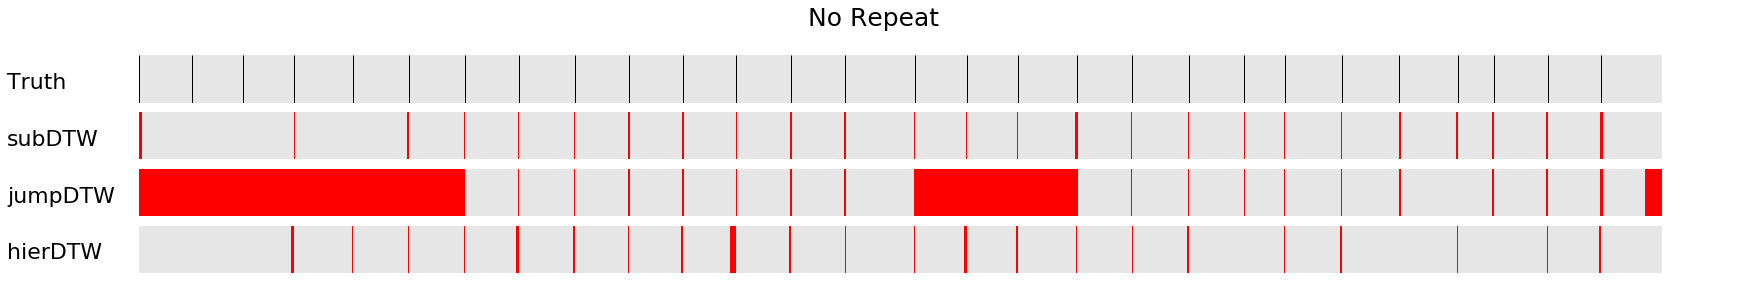

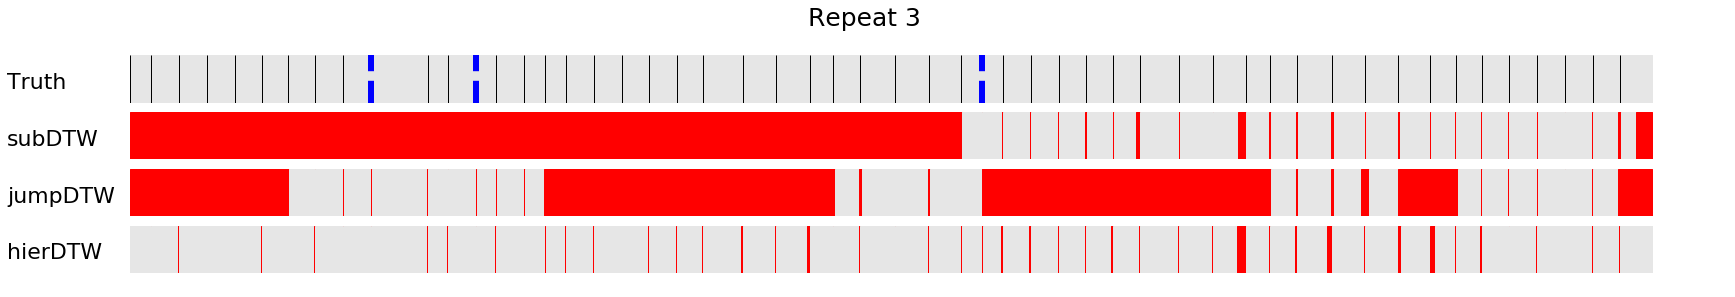

In [26]:
fig1 = errorPlotNoRepeat(4)
fig2 = errorPlotRepeat(48, data='data_repeat3')

### Error Analysis

In [335]:
piece = 4
with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(piece), 'rb') as f:
    d = pickle.load(f)
    events = d['events']
with open('/home/mshan/ttemp/data/hyp/hierarchicalDTW_v3.AD/{}/0.7/p{}.pkl'.format('data', piece), 'rb') as f:
    d = pickle.load(f)
    times = d['actual_time']
    lines = d['pred_lines']

In [336]:
bounds = getBoundaryElements(piece, "F")
prev_line = -1
for idx, line in enumerate(lines):
    if line != prev_line:
        start_idx = bounds[line]
        start_event = events[start_idx]
        print("P{}L{} starts at {}.".format(start_event[5]+1, start_event[2]+1, times[idx]))
    prev_line = line

P21L1 starts at 0.0.
P21L2 starts at 4.800000000000001.
P21L3 starts at 9.4.
P21L4 starts at 13.8.
P21L5 starts at 19.3.
P21L6 starts at 24.400000000000002.
P22L1 starts at 29.5.
P22L2 starts at 34.2.
P22L3 starts at 39.400000000000006.
P22L4 starts at 44.400000000000006.
P22L5 starts at 49.2.
P23L1 starts at 53.7.
P23L2 starts at 59.0.
P23L3 starts at 64.2.
P23L4 starts at 70.4.
P23L5 starts at 74.9.
P24L1 starts at 79.7.
P24L2 starts at 85.10000000000001.
P24L3 starts at 90.30000000000001.
P24L4 starts at 95.2.
P24L5 starts at 100.4.
P24L6 starts at 104.0.
P25L1 starts at 109.10000000000001.
P25L2 starts at 114.5.
P25L3 starts at 119.7.
P25L4 starts at 123.10000000000001.
P25L5 starts at 127.9.
P25L6 starts at 132.6.
